In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,KFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC,LinearSVC
from sklearn import metrics
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
!pip install rpy2 
!pip install -U imbalanced-learn

import rpy2.robjects as robjects
from rpy2.robjects.packages import STAP
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter


import rpy2
import rpy2.robjects as robjects


Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


     |████████████████████████████████| 163kB 6.0MB/s 
     |████████████████████████████████| 7.0MB 47.7MB/s 
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


# 0.0 Access Google drive

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 0.1 Helper function

In [0]:
def printCV(model, X_train, y_train, cvNum):
    acv = cross_val_score(model, X_train, y_train, cv=cvNum,scoring = "accuracy")
    pcv = cross_val_score(model, X_train, y_train, cv=cvNum,scoring = "precision")
    rcv = cross_val_score(model, X_train, y_train, cv=cvNum,scoring = "recall")
    cvmetric1 ="CV Accuracy:  "+ str(np.mean(acv))
    cvmetric2 = "CV Precision: "+ str(np.mean(pcv))
    cvmetric3 = "CV Recall:    "+ str(np.mean(rcv))
    print(cvmetric1)
    print(cvmetric2)
    print(cvmetric3)
    return cvmetric1,cvmetric2,cvmetric3


In [0]:
def writeToFile(modalName,aORw, metric1,metric2,metric3,metric4,cvmetric1,cvmetric2,cvmetric3):
  print(metric1)
  print(metric2)
  print(metric3)
  print(metric4)
  with open("result.txt", aORw) as out:
    out.write(modalName+" result:\n")
    out.write("   "+cvmetric1+"\n")
    out.write("   "+cvmetric2+"\n")
    out.write("   "+cvmetric3+"\n")
    out.write("   "+metric1+"\n")
    out.write("   "+metric2+"\n")
    out.write("   "+metric3+"\n")
    out.write("   "+metric4+"\n")

In [0]:
def highest_k(highest_recall,highest_recall_k,highest_auc,highest_auc_k, recall, auc, k):
  if(recall > highest_recall):
    highest_recall = recall
    highest_recall_k = k
  if(auc > highest_auc):
    highest_auc = auc
    highest_auc_k = k
  return highest_recall,highest_recall_k,highest_auc,highest_auc_k


In [0]:
def normalizer(someseries):
    maxval = max(someseries)
    minval = min(someseries)
    newseries = (someseries - minval)/(maxval-minval)
    return newseries

# 1.0 Process Data 

# 2.0 feature selection

## 2.1 Filter: correlation 

In [0]:
#Using Pearson Correlation
def correlation(kkk):
  plt.figure(figsize=(50,50))
  cor = df.corr()
  sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
  # plt.show()
  #Correlation with output variable
  cor_target = abs(cor["Label"])
  #Selecting highly correlated features
  temp = cor_target.nlargest(kkk+1) # 1 for label
  columns = cor_target>=temp[len(temp)-1]
  columns = columns[:-1]
  c=pd.DataFrame(columns)
  c.columns = ["Chosen"]
  c.set_index(df.columns[:-1])
  return columns

## 2.2 Filter: Chi2

In [0]:
def chi(kkk):
  inputfeatures = len(df.columns) - 1
  X = df.iloc[:,:inputfeatures]
  Y = df.iloc[:, inputfeatures:]

  # feature extraction
  ####### change k = number of all feature to avoid feature selection #####
  test = SelectKBest(score_func=chi2, k=kkk)
  fit = test.fit(X, Y)
  # summarize scores
  np.set_printoptions(precision=3)
  print(fit.scores_)
  features = fit.transform(X)
  # summarize selected features
  print(fit.get_support())
  columns = fit.get_support()
  c=pd.DataFrame(columns)
  c.columns = ["Chosen"]
  c.set_index(df.columns[:-1])
  # temp = df.columns[:-1]
  # temp[c["Chosen"] == True]
  return columns

## 2.3 Wraper: Recursive Feature Elimination

In [0]:
def wraper():
  inputfeatures = len(df.columns) - 1
  X = df.iloc[:,:inputfeatures]
  Y = df.iloc[:, inputfeatures:]

  # feature extraction
  model = LogisticRegression(solver='lbfgs')
  rfe = RFE(model, kFeature)
  fit = rfe.fit(X, Y)
  columns = fit.support_
  print("Selected Features: %s" % fit.support_)

  c=pd.DataFrame(columns)
  c.columns = ["Chosen"]
  c.set_index(df.columns[:-1])
  return columns

# 3.0 Split Train and Test Dataset

In [0]:
def splitTrainTest():
  inputfeatures = len(df.columns) - 1
  if(crossProject):
    inputfeaturesTest = len(dfTest.columns) - 1
    inputAllTest = dfTest.iloc[:,:inputfeatures]
    print(inputAllTest)
    outputdfTest = dfTest.iloc[:, inputfeatures:]

  inputAll = df.iloc[:,:inputfeatures]
  outputdf = df.iloc[:, inputfeatures:]
  # print(inputAll)
  # print(outputdf)

  c = pd.Series(columns)
  if(crossProject):

    inputdfTest = inputAllTest.iloc[:, c.values]
    # print(inputdfTest)
  inputdf = inputAll.iloc[:, c.values]
  # print(inputdf)

  if(crossProject):
    X_train =inputdf
    X_test =inputdfTest
    y_train =outputdf
    y_test = outputdfTest
  else:
    X_train, X_test, y_train, y_test = train_test_split(inputdf, outputdf, test_size=0.20, random_state=1)
  return X_train, X_test, y_train, y_test

##3.1 SMOTE


##3.1.1 SMOTE 


In [0]:
def smote():
  X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
  print(sorted(Counter(y_resampled).items()))
  return X_resampled, y_resampled

##3.1.2 SMOTENC

In [0]:
# from imblearn.over_sampling import SMOTE, ADASYN
# from collections import Counter
# from imblearn.over_sampling import SMOTENC
# smote_nc = SMOTENC(categorical_features=[0, 2], random_state=43)
# X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)
# print(sorted(Counter(y_resampled).items()))

##3.1.3 SVMSMOTE

In [0]:
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SVMSMOTE # doctest: +NORMALIZE_WHITESPACE

# sm = SVMSMOTE(random_state=42)
# X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
# print('Resampled dataset shape %s' % Counter(y_resampled))



```
# 此内容为代码格式
```

# 4.0 Models

## 4.1 3-layer NN

### 4.1.1 Basic 3-layer NN

In [0]:
def NN(y_test):

  model = Sequential()
  model.add(Dense(350, activation = 'sigmoid', input_dim = X_train.shape[1]))
  model.add(Dense(350, activation = 'sigmoid'))
  model.add(Dense(350, activation = 'sigmoid'))
  model.add(Dense(y_train.shape[1], activation = 'sigmoid'))

  model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
  model.fit(X_train, y_train, epochs = 220, verbose = False, batch_size = 1024, callbacks = [])

  y_pred = model.predict(X_test)
  # print(y_pred)
  y_pred = y_pred > 0.1
  y_test = np.array(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:  "+ str(accuracy)
  metric2 = "Precision: "+ str(precision)
  metric3 = "Recall:    "+ str(recall)

  nn_y_pred = y_pred
  nn_fpr, nn_tpr, threshold = metrics.roc_curve(y_test, nn_y_pred)
  plt.plot(nn_fpr, nn_tpr, marker='.', label='3-layer NN')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  nn_auc = metrics.auc(nn_fpr, nn_tpr)
  metric4 = "AUC:       " + str(metrics.auc(nn_fpr, nn_tpr))
  print(metric1)
  print(metric2)
  print(metric3)
  print(metric4)
  with open("result.txt", "a") as out:
    out.write("3-NN result:\n")
    out.write("   "+metric1+"\n")
    out.write("   "+metric2+"\n")
    out.write("   "+metric3+"\n")
    out.write("   "+metric4+"\n")
  

###4.1.2 SMOTE 3-layer NN



In [0]:
def NN_smote(y_test):
  model = Sequential()
  model.add(Dense(350, activation = 'sigmoid', input_dim = X_train.shape[1]))
  model.add(Dense(350, activation = 'sigmoid'))
  model.add(Dense(350, activation = 'sigmoid'))
  model.add(Dense(y_train.shape[1], activation = 'sigmoid'))

  model.compile(optimizer = 'adam', loss = 'binary_crossentropy')
  model.fit(X_resampled, y_resampled, epochs = 220, verbose = False, batch_size = 1024, callbacks = [])

  y_pred = model.predict(X_test)
  # print(y_pred)
  y_pred = y_pred > 0.1
  y_test = np.array(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:  "+ str(accuracy)
  metric2 = "Precision: "+ str(precision)
  metric3 = "Recall:    "+ str(recall)

  nn_y_pred = y_pred
  nn_fpr, nn_tpr, threshold = metrics.roc_curve(y_test, nn_y_pred)
  plt.plot(nn_fpr, nn_tpr, marker='.', label='3-layer NN')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  nn_auc = metrics.auc(nn_fpr, nn_tpr)
  metric4 = "AUC:       " + str(metrics.auc(nn_fpr, nn_tpr))
  print(metric1)
  print(metric2)
  print(metric3)
  print(metric4)
  with open("result.txt", "a") as out:
    out.write("3-NN-smore result:\n")
    out.write("   "+metric1+"\n")
    out.write("   "+metric2+"\n")
    out.write("   "+metric3+"\n")
    out.write("   "+metric4+"\n")

## 4.2 Naive Bayes

###4.2.1 Basic Naive Bayes

In [0]:
def NB(y_train,y_test):
  # gnb only accept shape[#sample,]
  y_train = np.array(y_train)
  y_train = y_train.reshape(y_train.shape[0],)

  gnb = MultinomialNB()
  #gnb = GaussianNB()
  cvmetric1, cvmetric2, cvmetric3 = printCV(gnb, X_train,y_train,5)
  clf_gnb = gnb.fit(X_train,y_train)

  y_pred = gnb.predict(X_test)
  # print(y_pred)
  y_pred = y_pred > 0.5
  y_test = np.array(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:     "+ str(accuracy)
  metric2 = "Precision:    "+ str(precision)
  metric3 = "Recall:       "+ str(recall)

  nb_y_pred = y_pred
  nb_fpr, nb_tpr, threshold = metrics.roc_curve(y_test, nb_y_pred)

  plt.plot(nb_fpr, nb_tpr, marker='.', label='NB')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  nb_auc = metrics.auc(nb_fpr, nb_tpr)
  metric4 = "AUC:          " + str(metrics.auc(nb_fpr, nb_tpr))
  writeToFile("Naive Bayes","a", metric1,metric2,metric3,metric4,cvmetric1,cvmetric2,cvmetric3)

###4.2.2 SMOTE Naive Bayes

In [0]:
def NB_smote(y_resampled,y_test):
  #X_resampled, y_resampled
  # gnb only accept shape[#sample,]
  y_resampled = np.array(y_resampled)
  y_resampled = y_resampled.reshape(y_resampled.shape[0],)

  gnb = MultinomialNB()
  #gnb = GaussianNB()
  #cvmetric1, cvmetric2, cvmetric3 = printCV(gnb, X_train,y_train,5)
  clf_gnb = gnb.fit(X_resampled,y_resampled)
  y_pred = gnb.predict(X_test)
  # print(y_pred)
  y_pred = y_pred > 0.5
  y_test = np.array(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:     "+ str(accuracy)
  metric2 = "Precision:    "+ str(precision)
  metric3 = "Recall:       "+ str(recall)

  nb_y_pred = y_pred
  nb_fpr, nb_tpr, threshold = metrics.roc_curve(y_test, nb_y_pred)

  plt.plot(nb_fpr, nb_tpr, marker='.', label='NB')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  nb_auc = metrics.auc(nb_fpr, nb_tpr)
  metric4 = "AUC:          " + str(metrics.auc(nb_fpr, nb_tpr))
  writeToFile("Naive Bayes smote","a", metric1,metric2,metric3,metric4,"Nil","Nil","Nil")

## 4.3 SVM

###4.3.1 Basic SVM

In [0]:
def svm(y_train,y_test):
  # clf only accept shape[#sample,]
  y_train = np.array(y_train)
  y_train = y_train.reshape(y_train.shape[0],)

  # svm_clf = SVC(gamma='auto')
  svm_clf = LinearSVC()
  cvmetric1, cvmetric2, cvmetric3 = printCV(svm_clf, X_train,y_train,5)

  svm_clf.fit(X_train,y_train) 

  y_pred = svm_clf.predict(X_test)
  print(y_pred)
  # y_pred = y_pred > 0.5
  y_test = np.array(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:     "+ str(accuracy)
  metric2 = "Precision:    "+ str(precision)
  metric3 = "Recall:       "+ str(recall)

  svm_y_pred = y_pred
  svm_fpr, svm_tpr, threshold = metrics.roc_curve(y_test, svm_y_pred)

  plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  svm_auc = metrics.auc(svm_fpr, svm_tpr)
  metric4 = "AUC:          " + str(metrics.auc(svm_fpr, svm_tpr))
  writeToFile("SVM","a", metric1,metric2,metric3,metric4,cvmetric1,cvmetric2,cvmetric3)

### 4.3.2 SMOTE SVM


In [0]:
def svm_smote(y_resampled,y_test):
  # clf only accept shape[#sample,]
  y_resampled = np.array(y_resampled)
  y_resampled = y_resampled.reshape(y_resampled.shape[0],)

  # svm_clf = SVC(gamma='auto')
  svm_clf = LinearSVC()


  svm_clf.fit(X_resampled,y_resampled) 
  y_pred = svm_clf.predict(X_test)
  print(y_pred)
  # y_pred = y_pred > 0.5
  y_test = np.array(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:     "+ str(accuracy)
  metric2 = "Precision:    "+ str(precision)
  metric3 = "Recall:       "+ str(recall)

  svm_y_pred = y_pred
  svm_fpr, svm_tpr, threshold = metrics.roc_curve(y_test, svm_y_pred)

  plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  svm_auc = metrics.auc(svm_fpr, svm_tpr)
  metric4 = "AUC:          " + str(metrics.auc(svm_fpr, svm_tpr))
  writeToFile("SVM-smote","a", metric1,metric2,metric3,metric4,"Nil","Nil","Nil")

## 4.4 XGBoost

###4.4.1 Basic XGBoost

In [0]:
def xgboost(X_train,X_test,y_train,y_test):
  #xg=xgb.XGBClassifier(random_state=1,learning_rate=0.01, n_estimators = 100)
  xg=xgb.XGBClassifier(random_state=1,learning_rate=0.01, n_estimators = 10)

  cvmetric1, cvmetric2, cvmetric3 = printCV(xg, X_train,y_train,5)

  xg.fit(X_train, y_train)

  y_pred = xg.predict(X_test)
  y_test = np.array(y_test)
  print(y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:     "+ str(accuracy)
  metric2 = "Precision:    "+ str(precision)
  metric3 = "Recall:       "+ str(recall)

  xg_y_pred = y_pred
  xg_fpr, xg_tpr, threshold = metrics.roc_curve(y_test, xg_y_pred)

  plt.plot(xg_fpr, xg_tpr, marker='.', label='XG boost')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  xg_auc = metrics.auc(xg_fpr, xg_tpr)
  metric4 = "AUC:          " + str(metrics.auc(xg_fpr, xg_tpr))
  writeToFile("XGBoost","a", metric1,metric2,metric3,metric4,cvmetric1,cvmetric2,cvmetric3)

###4.4.2 SMOTE XGBoost


In [0]:
def xgboost_smote(X_train,X_test,y_train,y_test):
  #xg=xgb.XGBClassifier(random_state=1,learning_rate=0.01, n_estimators = 100)
  xg=xgb.XGBClassifier(random_state=1,learning_rate=0.01, n_estimators = 10)

  xg.fit(X_resampled, y_resampled)
  X_test = X_test.as_matrix()
  X_train = X_train.as_matrix()
  y_pred = xg.predict(X_test)
  y_test = np.array(y_test)
  print(y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:     "+ str(accuracy)
  metric2 = "Precision:    "+ str(precision)
  metric3 = "Recall:       "+ str(recall)

  xg_y_pred = y_pred
  xg_fpr, xg_tpr, threshold = metrics.roc_curve(y_test, xg_y_pred)

  plt.plot(xg_fpr, xg_tpr, marker='.', label='XG boost')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  xg_auc = metrics.auc(xg_fpr, xg_tpr)
  metric4 = "AUC:          " + str(metrics.auc(xg_fpr, xg_tpr))
  writeToFile("XGBoost smote","a", metric1,metric2,metric3,metric4,"Nil","Nil","Nil")

## 4.5 Random forest

###4.5.1 Basic Random Forest

In [0]:
def RF(X_train,X_test,y_train,y_test):
  #'max_depth': 3, 'n_estimators': 1000
  #rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=1)
  rf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=1)

  cvmetric1, cvmetric2, cvmetric3 = printCV(rf, X_train,y_train,5)

  rf.fit(X_train,y_train) 

  y_pred = rf.predict(X_test)
  print(y_pred)
  # y_pred = y_pred > 0.5
  y_test = np.array(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:     "+ str(accuracy)
  metric2 = "Precision:    "+ str(precision)
  metric3 = "Recall:       "+ str(recall)

  rf_y_pred = y_pred
  rf_fpr, rf_tpr, threshold = metrics.roc_curve(y_test, rf_y_pred)

  plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  rf_auc = metrics.auc(rf_fpr, rf_tpr)
  metric4 = "AUC:          " + str(metrics.auc(rf_fpr, rf_tpr))
  writeToFile("Random Forest","a", metric1,metric2,metric3,metric4,cvmetric1,cvmetric2,cvmetric3)

###4.5.2 SMOTE Random Forest

In [0]:
def RF_smote(X_train,X_test,y_train,y_test):
  #'max_depth': 3, 'n_estimators': 1000
  #rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=1)
  rf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=1)


  rf.fit(X_resampled,y_resampled) 
  y_pred = rf.predict(X_test)
  print(y_pred)
  # y_pred = y_pred > 0.5
  y_test = np.array(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:     "+ str(accuracy)
  metric2 = "Precision:    "+ str(precision)
  metric3 = "Recall:       "+ str(recall)

  rf_y_pred = y_pred
  rf_fpr, rf_tpr, threshold = metrics.roc_curve(y_test, rf_y_pred)

  plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  rf_auc = metrics.auc(rf_fpr, rf_tpr)
  metric4 = "AUC:          " + str(metrics.auc(rf_fpr, rf_tpr))
  writeToFile("Random Forest smote","a", metric1,metric2,metric3,metric4,"Nil","Nil","Nil")

## 4.6 Logistic regression


### 4.6.1 Basic Logistic regression

In [0]:
def LR(X_train,X_test,y_train,y_test):
  # gnb only accept shape[#sample,]
  y_train = np.array(y_train)
  y_train = y_train.reshape(y_train.shape[0],)
  #'C': 0.001, 'solver': 'newton-cg'
  #lr = LogisticRegression(solver='newton-cg',C=0.001)
  lr = LogisticRegression(solver='liblinear')

  cvmetric1, cvmetric2, cvmetric3 = printCV(lr, X_train,y_train,5)

  clf_lr = lr.fit(X_train,y_train)

  y_pred = lr.predict(X_test)
  #y_pred = y_pred > 0.5
  y_test = np.array(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:     "+ str(accuracy)
  metric2 = "Precision:    "+ str(precision)
  metric3 = "Recall:       "+ str(recall)
  lr_y_pred = y_pred
  lr_fpr, lr_tpr, threshold = metrics.roc_curve(y_test, lr_y_pred)

  plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  lr_auc = metrics.auc(lr_fpr, lr_tpr)
  metric4 = "AUC:          " + str(metrics.auc(lr_fpr, lr_tpr))
  writeToFile("Logestic Regression","a", metric1,metric2,metric3,metric4,cvmetric1,cvmetric2,cvmetric3);

###4.6.2 SMOTE Logistic regression


In [0]:
def LR_smote(X_train,X_test,y_train,y_test,y_resampled):
  # gnb only accept shape[#sample,]
  y_resampled = np.array(y_resampled)
  y_resampled = y_resampled.reshape(y_resampled.shape[0],)
  #'C': 0.001, 'solver': 'newton-cg'
  #lr = LogisticRegression(solver='newton-cg',C=0.001)
  lr = LogisticRegression(solver='liblinear')

  clf_lr = lr.fit(X_resampled,y_resampled)
  y_pred = lr.predict(X_test)
  #y_pred = y_pred > 0.5
  y_test = np.array(y_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  metric1 ="Accuracy:     "+ str(accuracy)
  metric2 = "Precision:    "+ str(precision)
  metric3 = "Recall:       "+ str(recall)
  lr_y_pred = y_pred
  lr_fpr, lr_tpr, threshold = metrics.roc_curve(y_test, lr_y_pred)

  plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  lr_auc = metrics.auc(lr_fpr, lr_tpr)
  metric4 = "AUC:          " + str(metrics.auc(lr_fpr, lr_tpr))
  writeToFile("Logestic Regression smote","a", metric1,metric2,metric3,metric4,"Nil","Nil","Nil");

##4.7 Grid Search


In [0]:
# svm_parameters = [
#   { 'gamma': [0.001, 0.0001], 'kernel': ['linear']},
#   { 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
# ]
# svm_clf = GridSearchCV(SVC(), param_grid=svm_parameters, cv=2)
# svm_clf.fit(X_train,y_train)

In [0]:
#xg=xgb.XGBClassifier(random_state=1,learning_rate=0.01, n_estimators = 100)
xg_tuned_parameters = {'random_state':[1,2,3],'learning_rate':[0.01,0.1,1],
                       'n_estimators':[10,100,1000],'max_features':['sqrt','log2','None']}
xg_clf = GridSearchCV(xgb.XGBClassifier(), xg_tuned_parameters, cv=3, scoring="accuracy")
xg_clf.fit(X_train,y_train) 
print("tuned hpyerparameters :(best parameters) ",xg_clf.best_params_)


tuned hpyerparameters :(best parameters)  {'learning_rate': 0.1, 'max_features': 'sqrt', 'n_estimators': 10, 'random_state': 1}


In [0]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=1)
rf_tuned_parameters = {'n_estimators':[1000,2000,3000],'max_depth':[3,5,9],'min_samples_split':[2,5,10]}
rf_clf = GridSearchCV(RandomForestClassifier(), rf_tuned_parameters, cv=3, scoring="accuracy")
rf_clf.fit(X_train,y_train) 
print("tuned hpyerparameters :(best parameters) ",rf_clf.best_params_)

In [0]:
tuned_parameters = {'C': [1e-9,1e-7,1e-5,1e-3],
                    'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')
                    }
clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=3, scoring="accuracy")
clf.fit(X_train, y_train)
print("tuned hpyerparameters :(best parameters) ",clf.best_params_)

##4.8 Connectivity-based model

In [0]:
def cbm(X_train,X_test,y_train,y_test):
  robjects.r('''
        source('drive/My Drive/762/spectral_clustering_based_classifier.r')
  ''')

  r_unsupervised = robjects.globalenv['spectral_clustering_based_classifier']

  X_train_size=X_train.shape[0]
  X_test_size=X_test.shape[0]

  frames = [X_train,X_test]
  r_dataframe = pd.concat(frames)

  from rpy2.robjects import default_converter
  from rpy2.robjects.conversion import Converter, localconverter
  with localconverter(default_converter + pandas2ri.converter) as cv:
      r_data = pandas2ri.py2ri(r_dataframe)


  y_train = np.array(y_train)
  y_full = np.concatenate((y_train,y_test),axis=None)

  unsupervised_result = r_unsupervised(r_data)
  with localconverter(default_converter + pandas2ri.converter) as cv:
      unsupervised_result_full = pandas2ri.ri2py(unsupervised_result)
  y_train_unsupervised_result = unsupervised_result_full[0:X_train_size]
  y_test_unsupervised_result = unsupervised_result_full[X_train_size:]
  accuracy = accuracy_score(y_test, y_test_unsupervised_result)
  precision = precision_score(y_test, y_test_unsupervised_result)
  recall = recall_score(y_test, y_test_unsupervised_result)
  # print(accuracy)
  # print(precision)
  # print(recall)
  us_y_pred = y_test_unsupervised_result
  us_fpr, us_tpr, threshold = metrics.roc_curve(y_test, us_y_pred)

  plt.plot(us_fpr, us_tpr, marker='.', label='Connectivity based')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()
  us_auc = metrics.auc(us_fpr, us_tpr)
  # print(us_auc)
  writeToFile("Unsupervised ","a", accuracy,precision,recall,us_auc,"Nil","Nil","Nil");

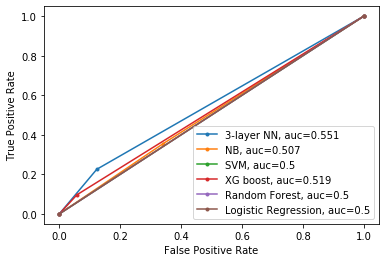

0.5


In [0]:
plt.plot(nn_fpr, nn_tpr, marker='.', label='3-layer NN, auc='+ str(round(nn_auc,3)))
plt.plot(nb_fpr, nb_tpr, marker='.', label='NB, auc='+ str(round(nb_auc,3)))
plt.plot(svm_fpr, svm_tpr, marker='.', label='SVM, auc='+ str(round(svm_auc,3)))
plt.plot(xg_fpr, xg_tpr, marker='.', label='XG boost, auc='+ str(round(xg_auc,3)))
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest, auc='+ str(round(rf_auc,3)))
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression, auc='+ str(round(lr_auc,3)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print(metrics.auc(rf_fpr, rf_tpr))

# Main

In [28]:
# path = "drive/My Drive/762/labeled_datasets/java/"
path = "drive/My Drive/762/labeled_datasets/C/"
# names = ['spring-framework_v5.1.0.csv',"maven3.0.csv","maven3.3.0.csv","guava_v20.0.csv","spring-boot_v1.4.0.csv"]
# names = ["maven3.3.0.csv", "maven3.0.csv"]
names = ["mpv_v0.3.0-label.csv","neovim_v0.2.0-label.csv","openssl_OpenSSL_1_1_0-label.csv","git_v2.11.0-label.csv"]
# dropColumns = ["Unnamed: 0","Name"]
dropColumns = ["Unnamed: 0","Name","File","CountDeclClass"]
crossProject = True
kFeature = range(30,40)
highest_recall = 0
highest_recall_k = 0
highest_auc = 0
highest_auc_k = 0

# this is where you should specify which project to use
df = pd.read_csv(path+names[0])

if(crossProject):
  for idx in range(1,len(names)-1):
    print(names[idx])
    df = df.append(pd.read_csv(path + names[idx]),ignore_index = True)
  print("\ndfTest: " + names[len(names)-1])
  dfTest = pd.read_csv(path + names[len(names)-1])
  dfTest = dfTest.drop(columns = dropColumns)
  df1 = dfTest.pop('Label')
  dfTest["Label"]= df1
  dfTest = dfTest.apply(normalizer)
  print(dfTest)
df = df.drop(columns = dropColumns)
df1 = df.pop('Label')
df["Label"]= df1
df = df.apply(normalizer)
df.head(5)

neovim_v0.2.0-label.csv
openssl_OpenSSL_1_1_0-label.csv

dfTest: git_v2.11.0-label.csv
     AltAvgLineBlank  AltAvgLineCode  ...  NumAuthor  Label
0            0.06250        0.108696  ...   0.118519    1.0
1            0.03125        0.065217  ...   0.081481    1.0
2            0.06250        0.103261  ...   0.051852    1.0
3            0.00000        0.038043  ...   0.051852    0.0
4            0.09375        0.135870  ...   0.162963    1.0
..               ...             ...  ...        ...    ...
380          0.06250        0.168478  ...   0.066667    1.0
381          0.09375        0.119565  ...   0.022222    1.0
382          0.15625        0.146739  ...   0.044444    0.0
383          0.09375        0.092391  ...   0.103704    0.0
384          0.03125        0.065217  ...   0.029630    1.0

[385 rows x 43 columns]


,AltAvgLineBlank,AltAvgLineCode,AltAvgLineComment,AltCountLineBlank,AltCountLineCode,AltCountLineComment,AvgCyclomatic,AvgCyclomaticModified,AvgCyclomaticStrict,AvgEssential,AvgLine,AvgLineBlank,AvgLineCode,AvgLineComment,CountDeclFunction,CountLine,CountLineBlank,CountLineCode,CountLineCodeDecl,CountLineCodeExe,CountLineComment,CountLineInactive,CountLinePreprocessor,CountSemicolon,CountStmt,CountStmtDecl,CountStmtEmpty,CountStmtExe,MaxCyclomatic,MaxCyclomaticModified,MaxCyclomaticStrict,MaxEssential,MaxNesting,RatioCommentToCode,SumCyclomatic,SumCyclomaticModified,SumCyclomaticStrict,SumEssential,NumRevision,NumAdded,NumDeleted,NumAuthor,Label
0,0.000000,0.009946,0.000000,0.001701,0.000953,0.005255,0.017094,0.017094,0.016807,0.015873,0.008447,0.000000,0.010442,0.000000,0.001621,0.001641,0.001722,0.000796,0.000423,0.000178,0.005305,0.000000,0.006424,0.000722,0.000790,0.001128,0.0,0.000665,0.001340,0.001442,0.001340,0.004167,0.083333,0.031429,0.000544,0.000573,0.000422,0.000589,0.000769,0.000873,0.000000,0.0,0.0
1,0.053571,0.011477,0.004950,0.006803,0.003275,0.008671,0.034188,0.034188,0.033613,0.031746,0.011696,0.053571,0.012048,0.004975,0.004862,0.004481,0.006888,0.002941,0.000658,0.001513,0.008753,0.000000,0.014989,0.003370,0.003477,0.004513,0.0,0.003105,0.003349,0.003605,0.004019,0.016667,0.166667,0.014082,0.002992,0.003150,0.002533,0.004711,0.002306,0.002539,0.000625,0.0,1.0
2,0.089286,0.029074,0.019802,0.014881,0.012860,0.015239,0.085470,0.076923,0.109244,0.047619,0.028590,0.089286,0.029719,0.019900,0.008104,0.012999,0.015067,0.012743,0.003620,0.006541,0.015385,0.000000,0.017131,0.015768,0.013831,0.019746,0.0,0.011642,0.009377,0.010094,0.016745,0.037500,0.416667,0.005714,0.013602,0.013459,0.014141,0.011190,0.000769,0.006849,0.000057,0.0,1.0
3,0.053571,0.054323,0.039604,0.008929,0.018397,0.015239,0.247863,0.170940,0.319328,0.031746,0.050032,0.053571,0.057028,0.039801,0.006483,0.016193,0.009040,0.018195,0.002209,0.007876,0.015385,0.000000,0.025696,0.026842,0.030823,0.020592,0.0,0.035148,0.064300,0.043980,0.089752,0.020833,0.416667,0.004082,0.031012,0.022623,0.032292,0.005889,0.000769,0.009096,0.000000,0.0,1.0
4,0.071429,0.026014,0.014851,0.005527,0.004465,0.008671,0.068376,0.068376,0.075630,0.047619,0.025991,0.071429,0.023293,0.014925,0.003241,0.005191,0.005596,0.003553,0.000564,0.001958,0.008488,0.003708,0.023555,0.005055,0.004663,0.003385,0.0,0.005211,0.008707,0.009373,0.010047,0.012500,0.333333,0.011224,0.004353,0.004582,0.003799,0.003534,0.000769,0.002750,0.000000,0.0,1.0


In [29]:
with open("result.txt", "w") as out:
  out.write("result:\n")
for kkk in kFeature:
  with open("result.txt", "a") as out:
    out.write("################### k: "+ str(kkk)+ " ##################\n")
  ######### 2.0 filter ############
  # columns = correlation(kkk)
  columns = chi(kkk)

  ######### 3.0 split #########
  X_train, X_test, y_train, y_test = splitTrainTest()

  ######### 3.1 smote #########
  X_resampled, y_resampled = smote()

  ######### 4.0 models #########
  NN(y_test)
  NN_smote(y_test)
  NB(y_train,y_test)
  NB_smote(y_resampled,y_test)
  svm(y_train,y_test)
  svm_smote(y_resampled,y_test)
  xgboost(X_train,X_test,y_train,y_test)
  xgboost_smote(X_train,X_test,y_train,y_test)
  RF(X_train,X_test,y_train,y_test)
  RF_smote(X_train,X_test,y_train,y_test)
  LR(X_train,X_test,y_train,y_test)
  LR_smote(X_train,X_test,y_train,y_test,y_resampled)
  # cbm(X_train,X_test,y_train,y_test)

Output hidden; open in https://colab.research.google.com to view.